# Import Torch and enable gpu

In [23]:
import torch 
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

In [24]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import torchvision

In [25]:
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
image_path = "./data/capsule/train/good/000.png"
image = Image.open(image_path)
print(image.size)

(900, 900)


In [27]:
transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
image = transforms(image)

torch.Size([3, 224, 224])


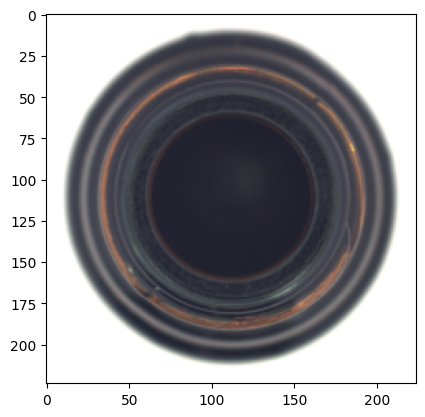

In [28]:
print(image.shape)
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.show()

# Memory

In [29]:
memory_usage = image.numel() * image.element_size()
print(f"Memory usage: {memory_usage / (1024 ** 2):.2f} MB")
print(f'Memory for all 208 images: {memory_usage * 208 / (1024 ** 2):.2f} MB')

Memory usage: 0.57 MB
Memory for all 208 images: 119.44 MB


In [ ]:
train_image_folder = ImageFolder(root="./data/capsule/train", transform=transforms)
x, y = train_image_folder[0]
print(f"Image shape: {x.shape}, Label: {y}")

Image shape: torch.Size([3, 224, 224]), Label: 0


In [31]:
train_dataset,val_dataset = torch.utils.data.random_split(train_image_folder, [0.8, 0.2])
print(f"Train dataset size: {len(train_dataset)}")

Train dataset size: 168


# Dataloading


In [32]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

image_batch, labels = next(iter(train_loader))
print(f"Batch image shape: {image_batch.shape}, Batch labels shape: {labels.shape}")

memory_usage_batch = image_batch.numel() * image_batch.element_size()
print(f"Memory usage for batch: {memory_usage_batch / (1024 ** 2):.2f} MB")

Batch image shape: torch.Size([16, 3, 224, 224]), Batch labels shape: torch.Size([16])
Memory usage for batch: 9.19 MB


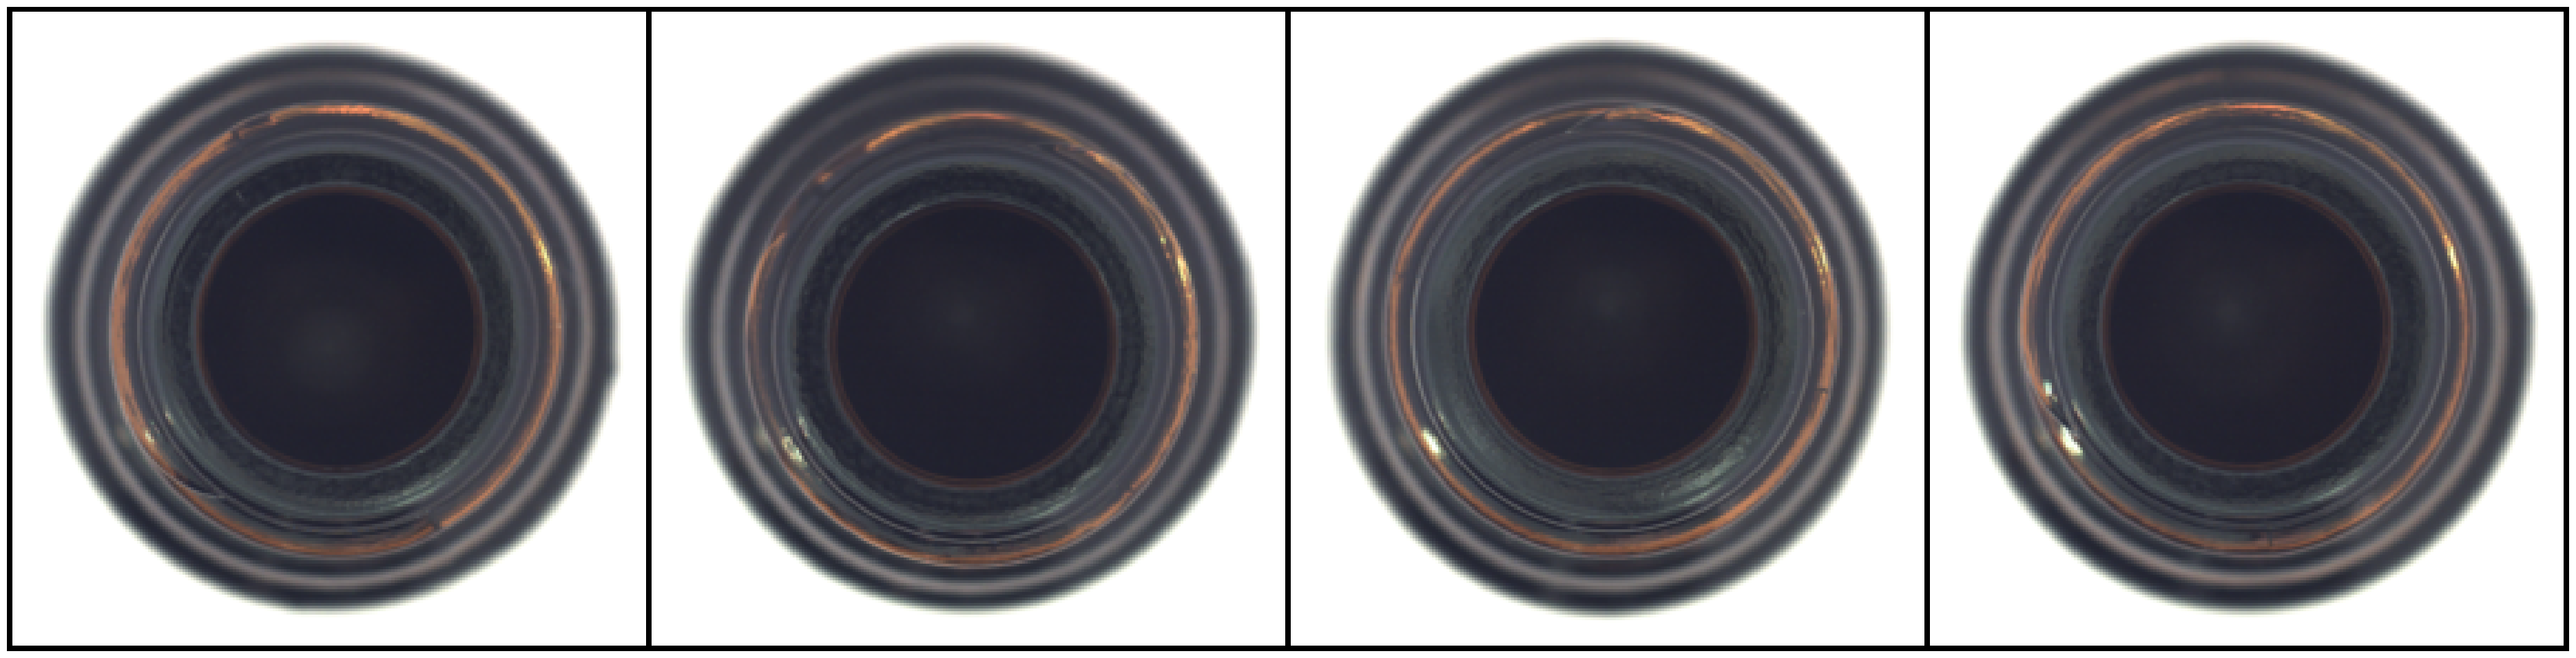

In [33]:
plt.figure(figsize=(12*4, 8*4))
grid_size = torchvision.utils.make_grid(image_batch[0:4], nrow=4)
plt.imshow(np.transpose(grid_size.numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

In [ ]:
input_image = Image.open(r'.\data\capsule\train\good\000.png')
input_image = transforms(input_image) 

input_image = input_image.unsqueeze(0) 

c1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4)
x = c1(input_image)
print(x.shape)
ap1 = nn.AvgPool2d(kernel_size=2, stride=2 )
x = ap1(x)
print(x.shape)
c2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4)
ap2 = nn.AvgPool2d(kernel_size=2, stride=2 )
x= ap2(c2(x))
print(x.shape)
c3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3 )
ap3 = nn.AvgPool2d(kernel_size=2, stride=2 )
x = ap3(c3(x))
print(x.shape)

c4 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=4, stride=2, output_padding=1 )
x = c4(x)
print(x.shape)
c5 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=5, stride=2, output_padding=1 )
x = c5(x)
print(x.shape)
c6 = nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=5, stride=2, output_padding=1 )
x = c6(x)
print(x.shape)

torch.Size([1, 128, 221, 221])
torch.Size([1, 128, 110, 110])
torch.Size([1, 256, 53, 53])
torch.Size([1, 256, 25, 25])
torch.Size([1, 256, 53, 53])
torch.Size([1, 128, 110, 110])
torch.Size([1, 3, 224, 224])


In [35]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, output_padding=1 ),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=5, stride=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder()  
input_image = torch.randn(1, 3, 224, 224) 
output_image = model(input_image)
print(output_image.shape)  

torch.Size([1, 3, 224, 224])


In [36]:
ckpoints = torch.load('simple_autoencoder_l2_loss.pth')
model.load_state_dict(ckpoints)

model.cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

  1%|          | 1/100 [00:05<08:49,  5.35s/it]

Epoch [1/100], Loss: 0.0048, Validation Loss: 0.0045


  6%|▌         | 6/100 [00:24<06:14,  3.98s/it]

Epoch [6/100], Loss: 0.0033, Validation Loss: 0.0033


 11%|█         | 11/100 [00:44<05:45,  3.88s/it]

Epoch [11/100], Loss: 0.0032, Validation Loss: 0.0031


 16%|█▌        | 16/100 [01:03<05:25,  3.88s/it]

Epoch [16/100], Loss: 0.0029, Validation Loss: 0.0029


 21%|██        | 21/100 [01:23<05:07,  3.89s/it]

Epoch [21/100], Loss: 0.0028, Validation Loss: 0.0028


 26%|██▌       | 26/100 [01:42<04:50,  3.93s/it]

Epoch [26/100], Loss: 0.0027, Validation Loss: 0.0027


 31%|███       | 31/100 [02:02<04:30,  3.93s/it]

Epoch [31/100], Loss: 0.0026, Validation Loss: 0.0026


 36%|███▌      | 36/100 [02:21<04:08,  3.88s/it]

Epoch [36/100], Loss: 0.0025, Validation Loss: 0.0025


 41%|████      | 41/100 [02:41<03:47,  3.85s/it]

Epoch [41/100], Loss: 0.0024, Validation Loss: 0.0024


 46%|████▌     | 46/100 [03:00<03:27,  3.84s/it]

Epoch [46/100], Loss: 0.0023, Validation Loss: 0.0022


 51%|█████     | 51/100 [03:19<03:07,  3.84s/it]

Epoch [51/100], Loss: 0.0022, Validation Loss: 0.0022


 56%|█████▌    | 56/100 [03:38<02:48,  3.84s/it]

Epoch [56/100], Loss: 0.0021, Validation Loss: 0.0021


 61%|██████    | 61/100 [03:57<02:29,  3.83s/it]

Epoch [61/100], Loss: 0.0020, Validation Loss: 0.0020


 66%|██████▌   | 66/100 [04:16<02:10,  3.83s/it]

Epoch [66/100], Loss: 0.0019, Validation Loss: 0.0019


 71%|███████   | 71/100 [04:36<01:51,  3.86s/it]

Epoch [71/100], Loss: 0.0018, Validation Loss: 0.0018


 76%|███████▌  | 76/100 [04:55<01:33,  3.90s/it]

Epoch [76/100], Loss: 0.0018, Validation Loss: 0.0018


 81%|████████  | 81/100 [05:16<01:22,  4.34s/it]

Epoch [81/100], Loss: 0.0017, Validation Loss: 0.0017


 86%|████████▌ | 86/100 [05:37<00:56,  4.04s/it]

Epoch [86/100], Loss: 0.0017, Validation Loss: 0.0017


 91%|█████████ | 91/100 [05:56<00:35,  3.89s/it]

Epoch [91/100], Loss: 0.0016, Validation Loss: 0.0016


 96%|█████████▌| 96/100 [06:16<00:15,  3.86s/it]

Epoch [96/100], Loss: 0.0015, Validation Loss: 0.0015


100%|██████████| 100/100 [06:31<00:00,  3.91s/it]


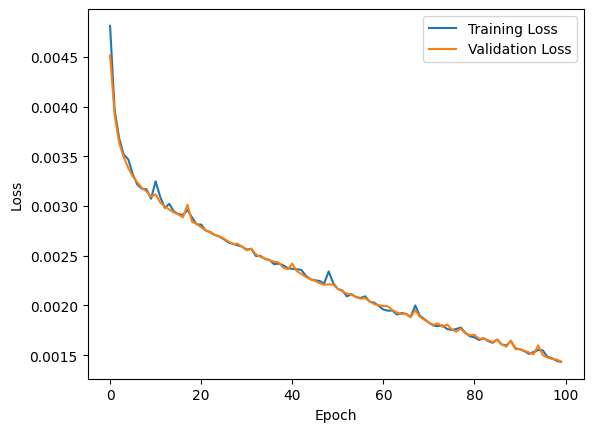

In [37]:
from tqdm import tqdm
Loss = []
Validation_Loss = []


num_epochs = 100
for epoch in tqdm(range(num_epochs)):
    model.train()  
    for img, _ in train_loader:
        img = img.cuda()
        
        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
    Loss.append(loss.item())
           
    model.eval()  
    with torch.no_grad():
        val_loss_sum = 0.0
        num_batches = 0
        for img, _ in val_loader:
            img = img.cuda()
            output = model(img)
            val_loss = criterion(output, img)
            val_loss_sum += val_loss.item()
            num_batches += 1
        val_loss_avg = val_loss_sum / num_batches
        Validation_Loss.append(val_loss_avg)
    
    if epoch % 5 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item(), val_loss_avg))

plt.plot(Loss, label='Training Loss')
plt.plot(Validation_Loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:

torch.save(model.state_dict(), 'simple_autoencoder_l2_loss.pth')
model.eval()

ckpoints = torch.load('simple_autoencoder_l2_loss.pth')
model.load_state_dict(ckpoints)

<All keys matched successfully>

torch.Size([16, 224, 224])


<Figure size 1600x1200 with 0 Axes>

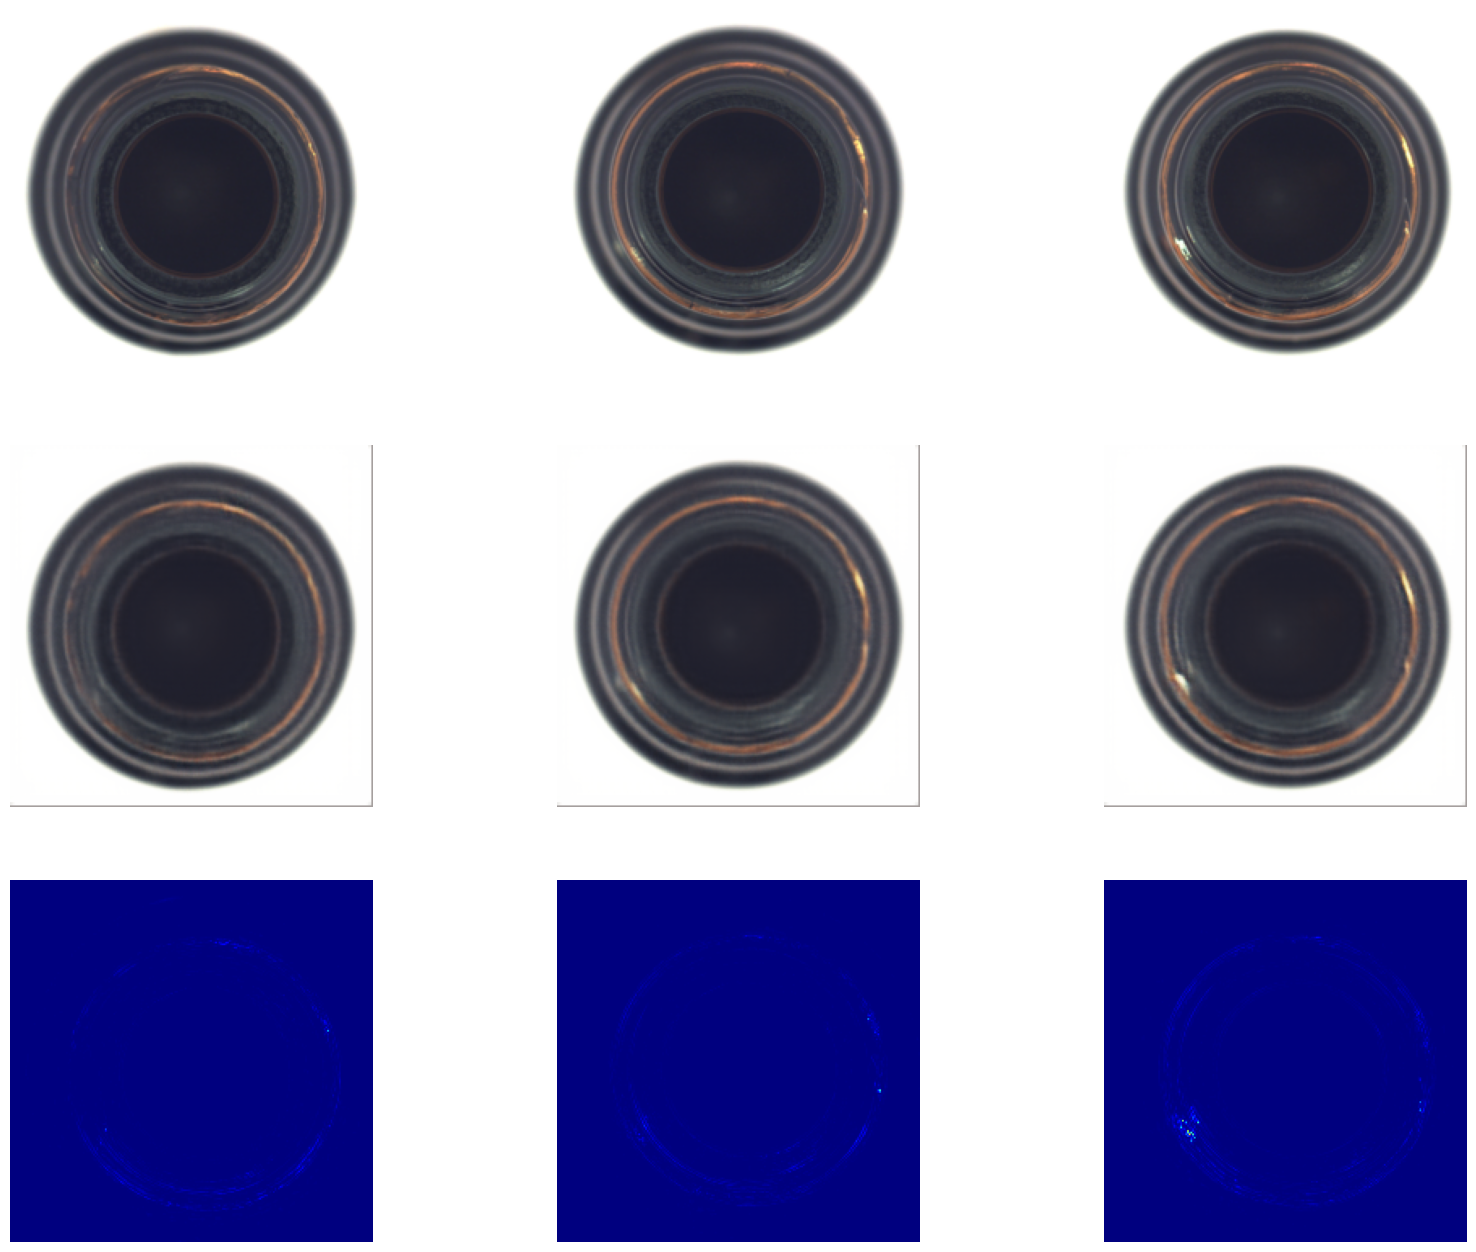

In [39]:
with torch.no_grad():
    for data, _ in train_loader:
        data = data.cuda()
        recon = model(data)
        break

recon_error =  ((data-recon)**2).mean(axis=1)
print(recon_error.shape)

plt.figure(dpi=250)
fig, ax = plt.subplots(3, 3, figsize=(5*4, 4*4))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[2, i].imshow(recon_error[i][0:-10,0:-10].cpu().numpy(), cmap='jet',vmax= torch.max(recon_error[i])) #[0:-10,0:-10]
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    ax[2, i].axis('OFF')
plt.show()

<Figure size 1600x1200 with 0 Axes>

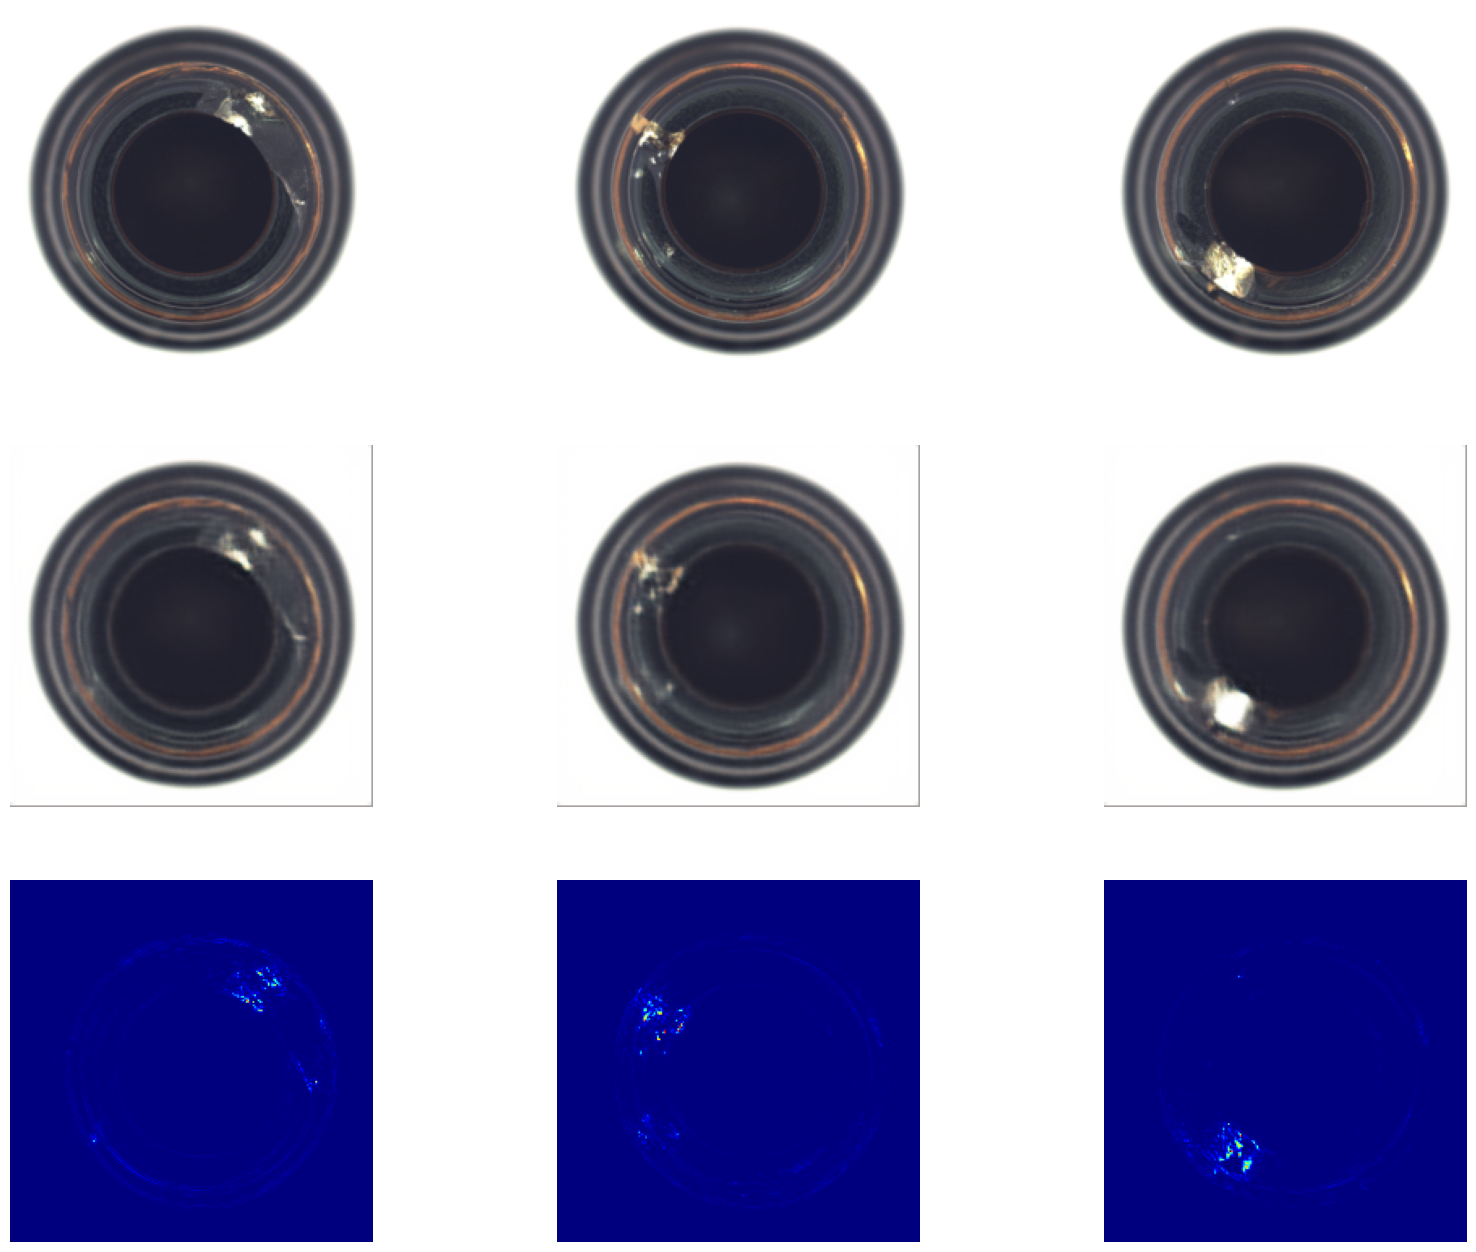

In [ ]:
test_image_1 = transforms(Image.open(r'data\capsule\test\crack\010.png'))
test_image_2 = transforms(Image.open(r'data\capsule\test\crack\001.png'))
test_image_3 = transforms(Image.open(r'data\capsule\test\crack\004.png'))

data = torch.stack([test_image_1,test_image_2, test_image_3])

with torch.no_grad():
    data = data.cuda()
    recon = model(data)
    
recon_error =  ((data-recon)**2).mean(axis=1)
    
plt.figure(dpi=250)
fig, ax = plt.subplots(3, 3, figsize=(5*4, 4*4))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[2, i].imshow(recon_error[i][0:-10,0:-10].cpu().numpy(), cmap='jet',vmax= torch.max(recon_error[i]))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    ax[2, i].axis('OFF')
plt.show()